# **Genomic Data Clustering**

In this notebook I'll use data from a genome and identify useful genes versus noise. Unfortunately, I don't know which sequences of genes are useful, so I'll use Unsupervised Learning to infer this.

### **Importing the Required Libraries**

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### **Data Preparation**


The file format often used for bioinformatics and genomic data is called **FASTA**. It is a normally encoded file with headers separating genetic information. I'll get the file ready and strip it of unwanted characters and store it as a string.

In [ ]:
# open the file and get an array of its lines
with open ("/content/drive/MyDrive/MIT_IDSS/1.1_Making Sense of Unstructured Data/Clustering/Hands-on Case Study/Genomic Data Clustering/ccrescentus.fa", "r") as inputFile:
    data = inputFile.readlines()

# concatenate each line from the second (first line is a description), stripped of empty chars
geneticCode = ''
for line in data[1:]:
    geneticCode += line.strip()

# count the presence of each genome(a,g,t,c)
aCount = geneticCode.count('a')
gCount = geneticCode.count('g')
tCount = geneticCode.count('t')
cCount = geneticCode.count('c')

# for testing I print a sample of the string and check if there are only wanted characters
print(geneticCode[0:30])
print('Test: only a,g,t,c ?')
print(aCount + gCount + tCount + cCount == len(geneticCode))

gccgatagcctatgatccccggcaggcccg
Test: only a,g,t,c ?
True


### **Converting Text to a Numerical Table**

#### **Creating Frequency Tables**
Now I've got a string element containing the sequence. The word is any continuous piece of text that contains several subsequent letters. As there are no spaces in the text, separation into words is not unique. The next step is to separate it into smaller sub-strings and create frequency tables for each x-sized word. I'll start by separating the string into a number of sub-strings, of a reasonable sample size, to become rows on our table.

**Considering what is a "reasonable size" for a data point**

Knowing that my string has 30k characters, and that I am checking words with a maximum of 4 - 5 letters, take a size of 300. It generates 1k data points, and allows for 60 5-letter words. I clip the whole text into fragments of 300 letters 4 in length and calculate the frequencies of short words (of length 1–4) inside every fragment. This will give me a description of the text in the form of a numerical table. There will be four such tables for every short word length choice from 1 to 4.

As there are only four letters, there are four possible words of length 1 (singlets), 16 = 4^2 possible words of length 2 (duplets), 64 = 4^3 possible words of length 3 (triplets) and 256 = 4^4 possible words of length 4 (quadruplets). The first table contains four columns (frequency of every singlet) and the number of rows equals the number of fragments. The second table has 16 columns and the same number of rows, and so on.

In [ ]:
# size of the sub strings (data points)
size = 300

dataPoints = []

# copy the entire code into a string, which will removed of its first elements iteratively
tempString = geneticCode

# iteratively remove a left chunk of the string and place it into our array
while len(tempString) > 0:
    dataPoints.append(tempString[0:size])
    tempString = tempString[size:]

print(dataPoints[0])

gccgatagcctatgatccccggcaggcccggggcttggagccgtctggtttggatggaaccctccaaaccagatcaagaggctcctagaacgccgcccgcagggtcacgccccaggtgcgcgggtcgcccggctggccggcgatcaggccggtgttgctgggacccacggccagttgctcgaaatagttctcgtcgaaggcgttgcggacccaggcatagaggttcagcccctcaggcgtgcggaagccggcccggaagttagcgatcgtgtagccgtcaacccaggtgtagatcgaggg


**Now create a list with the combinations of words possible**

In [ ]:
import itertools

iterables = ['a','g','t','c']
wordsDict =  {}

# for words of size 1 to 4, we calculate the cartesian product to get all possibilities
for i in range(1,5):
    words = []
    iterator = itertools.product(iterables, repeat = i)
    for word in iterator:
        s = ''
        for t in word:
            s += t
        words.append(s)
    wordsDict[i] = words

# print the dictionary for 3 letter words
print(wordsDict[3])

['aaa', 'aag', 'aat', 'aac', 'aga', 'agg', 'agt', 'agc', 'ata', 'atg', 'att', 'atc', 'aca', 'acg', 'act', 'acc', 'gaa', 'gag', 'gat', 'gac', 'gga', 'ggg', 'ggt', 'ggc', 'gta', 'gtg', 'gtt', 'gtc', 'gca', 'gcg', 'gct', 'gcc', 'taa', 'tag', 'tat', 'tac', 'tga', 'tgg', 'tgt', 'tgc', 'tta', 'ttg', 'ttt', 'ttc', 'tca', 'tcg', 'tct', 'tcc', 'caa', 'cag', 'cat', 'cac', 'cga', 'cgg', 'cgt', 'cgc', 'cta', 'ctg', 'ctt', 'ctc', 'cca', 'ccg', 'cct', 'ccc']


Now, I create a dataframe to begin the frequency matrix construction. From there, all that I have to do is to apply the count function for each word, and store it as a new column. I'll do this for all the 4 sizes of words.

In [ ]:
# dictionary that will contain the frequency table for each word size
freqTables = {}

for i in range(1,5):
    # create an empty dataFrame with columns being the words on the dictionary
    df = pd.DataFrame(columns = wordsDict[i])
    for index, dataP in enumerate(dataPoints):
        # create a row with zero values corresponding to a data point
        df.loc[index] = np.zeros(len(wordsDict[i]))
        while len(dataP) > 0:
            # get the left part of the data point (i characters)
            left = dataP[0:i]
            # find it in the respective column and count it there
            df.loc[index, left] += 1
            dataP = dataP[i:]
    freqTables[i] = df

freqTables[3].head()

,aaa,aag,aat,aac,aga,agg,agt,agc,ata,atg,...,cgt,cgc,cta,ctg,ctt,ctc,cca,ccg,cct,ccc
0,0.0,1.0,0.0,3.0,0.0,2.0,0.0,2.0,2.0,0.0,...,2.0,2.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,1.0
1,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,5.0,0.0,...,2.0,4.0,0.0,2.0,4.0,2.0,1.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,2.0,4.0,0.0,4.0,5.0,4.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4.0,0.0,5.0,5.0,2.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,2.0,2.0,0.0,8.0,3.0,1.0,5.0,1.0,0.0,0.0


Now, **data is ready in the optimal format to run PCA.**

### **Principal Component Analysis**

- One reason why I'm trying multiple word lengths, is because without additional domain knowledge it is not clear if there are more meaningful units I could work with than individual letters.  
- **So I calculate frequency tables to see if certain combinations happen more frequently (and more frequently together), and thus might be meaningful, than others.**
- PCA is helpful by creating natural clusters where combinations frequently co-occur and in reducing the dimensions also enables me to visualize the dataset in a way that's otherwise not possible.

- The first step to run PCA is to **standardize the data** across columns.
- I do this to have the **same averages and dispersions across the data**, which is an important concept of both PCA and K-means, as they are distance-based algorithms.
- The **StandardScaler** package is used to achieve this.

In [ ]:
normFreqTables = {}

for i in range(1,5):
    # eliminate the string column from the data, leaving only the actual frequencies
    data = freqTables[i]
    data = StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(data)
    normFreqTables[i] = pd.DataFrame(data, columns = wordsDict[i])

# for testing, check that the average of a column is close to zero and stdev close to 1(i.e. checking for normalization)
print(normFreqTables[2].loc[:, 'gt'].mean())
print(normFreqTables[2].loc[:, 'gt'].std())

-1.1178646776953396e-16
1.0004920049498167


In [ ]:
pca = PCA(n_components = 2)

pCompTables = {}

for i in range(1,5):
    pca.fit(normFreqTables[i])
    pComponents = pca.transform(normFreqTables[i])
    # for each word size, store the result of the PCA in a table containing only the 2 princicipal components
    pCompTables[i] = pd.DataFrame(pComponents[:, [0,1]], columns = ['pc1', 'pc2'])
    print('Explained variance for ' + str(i) + ' letters: ' + str(pca.explained_variance_ratio_.sum()))

print(pCompTables[2].head())

Explained variance for 1 letters: 0.7489363490534273
Explained variance for 2 letters: 0.22778150319652773
Explained variance for 3 letters: 0.31670201938180154
Explained variance for 4 letters: 0.02933505612162976
        pc1       pc2
0 -0.990267 -0.450031
1 -0.122061 -0.781226
2  1.183155  0.291047
3  0.543388  1.143493
4  0.105260  1.637501


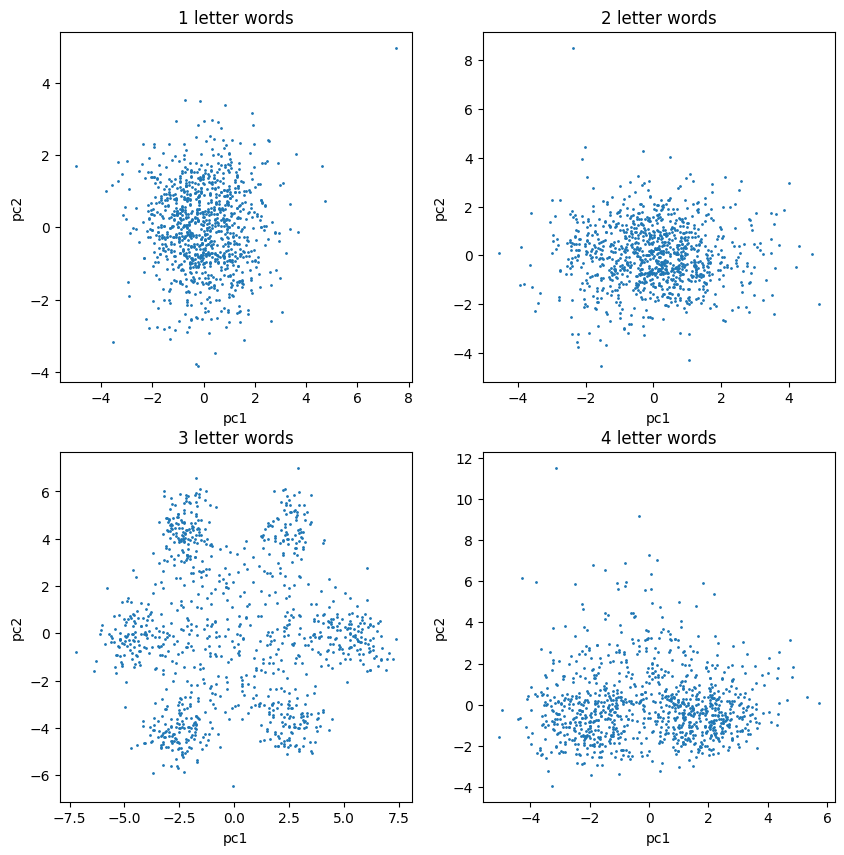

In [ ]:
# now  I finally need to plot these tables to try to find correlations visually
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i in range(1,5):
    plt.subplot(2,2,i)
    x = pCompTables[i].loc[:,'pc1']
    y = pCompTables[i].loc[:,'pc2']
    plt.scatter(x,y, s = 1)
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.title(str(i) + ' letter words')

plt.show()

From the plots I can clearly see that **3 letters** generates identifiable visual relations between data points in the first **two principal components**.

**Considering what do these clusters mean for the 3-letter words**

- I can identify 6 distinct poles, or centroids in the graph. If the genetic information is coded in 3-letter words, each of these clusters has similar distributions of frequencies of these words.

### **Clustering**
I will now cluster the 3 letter word gene breakdown using the K-means Clustering unsupervised algorithm. From the previous section, I can detect 6 or 7 clusters. Knowing that some genes do not carry information, I am led to think that the center points, far from the 6 distinct centroids, could be a candidate for those. I therefore assume that there are 7 clusters. (this could be checked by comparing the performance of 6 or 7 clustering)

In [ ]:
kmeans = KMeans(n_clusters = 7)
kmeans.fit(normFreqTables[3])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=7)

### **Results in a Graph**
Visualizing the cluster in different colors using the results,

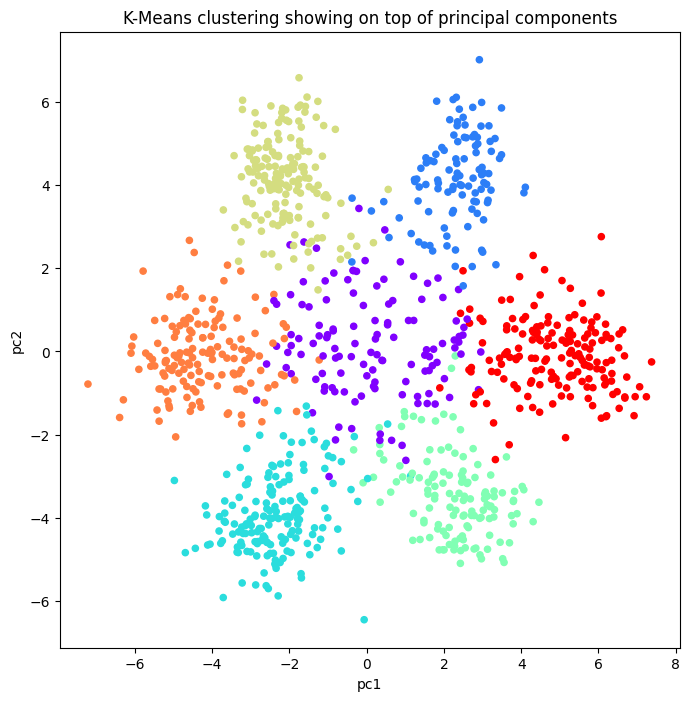

In [ ]:
plt.figure(figsize=(8,8))

x = pCompTables[3].loc[:,'pc1']
y = pCompTables[3].loc[:,'pc2']
plt.scatter(x,y, s = 20, c=kmeans.labels_, cmap = 'rainbow')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('K-Means clustering showing on top of principal components')

plt.show()

Hence, Unsupervised Learning through Clustering (K-means Clustering) and Dimensionality Reduction (PCA) has allowed me to **visualize, validate and provide supporting evidence for the biological discovery** that the DNA genetic sequence is organized into three-letter words,